# 실생활 예제로 PINNs 학습하기

## 문제 설명: 단순 조화 운동 (Spring-Mass System)

실생활에서 흔히 볼 수 있는 단순 조화 운동 문제를 해결해보겠습니다. 이는 스프링과 질량으로 이루어진 시스템의 진동을 설명합니다.

단순 조화 운동의 방정식은 다음과 같습니다:

$$
\frac{d^2x}{dt^2} + \omega^2 x = 0
$$

여기서:
$$
\begin{aligned}
& x : \text{질량의 변위 (m)} \\
& \omega : \text{각 진동수 (rad/s)}
\end{aligned}
$$

초기 조건:
$$
\begin{aligned}
& x(0) = x_0, \\
& \frac{dx}{dt}(0) = v_0.
\end{aligned}
$$

스프링-질량 시스템은 흔히 물리학과 공학에서 사용되며, 고등학생들 여러분도 쉽게 이해할 수 있는 문제입니다.

---

```python
# 필요한 라이브러리 불러오기
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
```

---

## 단순 조화 운동 PINN 정의

```python
# PINN 모델 정의
class PINN_SimpleHarmonic(nn.Module):
    def __init__(self):
        super(PINN_SimpleHarmonic, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # x(t) 출력
        )

    def forward(self, x):
        return self.layers(x)
```

---

## 손실 함수 정의

```python

# 손실 함수 정의
def loss_sho_with_ic(model, t, omega, x0, v0):
    # ODE Loss
    t.requires_grad = True
    x = model(t)
    dx_dt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt, t, grad_outputs=torch.ones_like(dx_dt), create_graph=True)[0]
    ode_loss = torch.mean((d2x_dt2 + omega**2 * x) ** 2)
    
    # Initial Condition Loss
    t0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True)  # 수정된 부분
    x0_pred = model(t0)
    dx0_pred = torch.autograd.grad(x0_pred, t0, grad_outputs=torch.ones_like(x0_pred), create_graph=True)[0]
    ic_loss = (x0_pred - x0)**2 + (dx0_pred - v0)**2

    return ode_loss + ic_loss

---

## 모델 학습 함수

```python
# 모델 학습 함수
def train_sho_model(model, t_train, loss_fn, omega, x0, v0, epochs=1000, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, t_train, omega, x0, v0)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
```

---

## 학습 및 결과 시각화

```python
# 초기 조건 및 매개변수 설정
x0 = 1.0      # 초기 변위 (m)
v0 = 0.0      # 초기 속도 (m/s)
omega = 2.0   # 각 진동수 (rad/s)

# 학습 데이터 생성
t_train = torch.linspace(0, 10, 100).view(-1, 1)  # 0초부터 10초까지

# PINN 모델 학습
model_sho = PINN_SimpleHarmonic()
train_sho_model(model_sho, t_train, loss_sho_with_ic, omega, x0, v0, epochs=10000)

# 결과 시각화
t_test = np.linspace(0, 10, 100)
t_test_tensor = torch.tensor(t_test, dtype=torch.float32).view(-1, 1)
x_pred = model_sho(t_test_tensor).detach().numpy()

# 참 해 계산
x_true = x0 * np.cos(omega * t_test) + (v0 / omega) * np.sin(omega * t_test)

plt.plot(t_test, x_true, label="True Solution")
plt.plot(t_test, x_pred, label="PINN Solution", linestyle='dashed')
plt.title("Simple Harmonic Oscillator")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.legend()
plt.show()
```


In [1]:
# 필요한 라이브러리 불러오기
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# PINN 모델 정의
class PINN_SimpleHarmonic(nn.Module):
    def __init__(self):
        super(PINN_SimpleHarmonic, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # x(t) 출력
        )

    def forward(self, x):
        return self.layers(x)

In [4]:
# 손실 함수 정의
def loss_sho_with_ic(model, t, omega, x0, v0):
    # ODE Loss
    t.requires_grad = True
    x = model(t)
    dx_dt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt, t, grad_outputs=torch.ones_like(dx_dt), create_graph=True)[0]
    ode_loss = torch.mean((d2x_dt2 + omega**2 * x) ** 2)

    # Initial Condition Loss
    t0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True)  # 수정된 부분
    x0_pred = model(t0)
    dx0_pred = torch.autograd.grad(x0_pred, t0, grad_outputs=torch.ones_like(x0_pred), create_graph=True)[0]
    ic_loss = (x0_pred - x0)**2 + (dx0_pred - v0)**2

    return ode_loss + ic_loss


## 모델 학습 함수


# 모델 학습 함수
def train_sho_model(model, t_train, loss_fn, omega, x0, v0, epochs=1000, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, t_train, omega, x0, v0)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 1.3818
Epoch 100, Loss: 0.2734
Epoch 200, Loss: 0.2051
Epoch 300, Loss: 0.1502
Epoch 400, Loss: 0.1366
Epoch 500, Loss: 0.1326
Epoch 600, Loss: 0.1304
Epoch 700, Loss: 0.1290
Epoch 800, Loss: 0.1270
Epoch 900, Loss: 0.1773
Epoch 1000, Loss: 0.1089
Epoch 1100, Loss: 0.1049
Epoch 1200, Loss: 0.1041
Epoch 1300, Loss: 0.1034
Epoch 1400, Loss: 0.1020
Epoch 1500, Loss: 0.0996
Epoch 1600, Loss: 0.2878
Epoch 1700, Loss: 0.0919
Epoch 1800, Loss: 0.0853
Epoch 1900, Loss: 0.0844
Epoch 2000, Loss: 0.0814
Epoch 2100, Loss: 0.0785
Epoch 2200, Loss: 0.0749
Epoch 2300, Loss: 0.0795
Epoch 2400, Loss: 0.0733
Epoch 2500, Loss: 0.0724
Epoch 2600, Loss: 0.0800
Epoch 2700, Loss: 0.0729
Epoch 2800, Loss: 0.0721
Epoch 2900, Loss: 0.1029
Epoch 3000, Loss: 0.0721
Epoch 3100, Loss: 0.0704
Epoch 3200, Loss: 0.1874
Epoch 3300, Loss: 0.0644
Epoch 3400, Loss: 0.0570
Epoch 3500, Loss: 0.0495
Epoch 3600, Loss: 0.0439
Epoch 3700, Loss: 0.0519
Epoch 3800, Loss: 0.0685
Epoch 3900, Loss: 0.1159
Epoch 4000, 

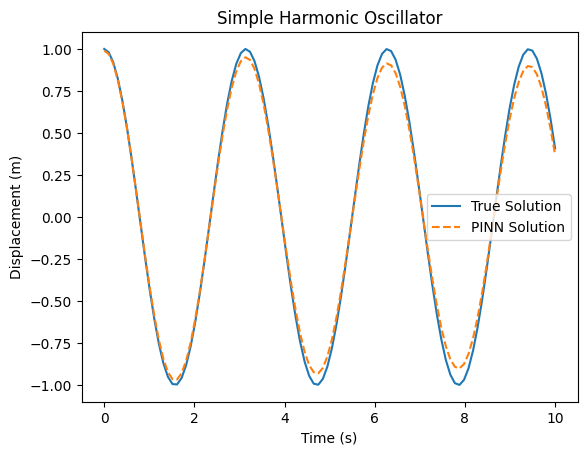

In [5]:
# 초기 조건 및 매개변수 설정
x0 = 1.0      # 초기 변위 (m)
v0 = 0.0      # 초기 속도 (m/s)
omega = 2.0   # 각 진동수 (rad/s)

# 학습 데이터 생성
t_train = torch.linspace(0, 10, 100).view(-1, 1)  # 0초부터 10초까지

# PINN 모델 학습
model_sho = PINN_SimpleHarmonic()
train_sho_model(model_sho, t_train, loss_sho_with_ic, omega, x0, v0, epochs=10000)

# 결과 시각화
t_test = np.linspace(0, 10, 100)
t_test_tensor = torch.tensor(t_test, dtype=torch.float32).view(-1, 1)
x_pred = model_sho(t_test_tensor).detach().numpy()

# 참 해 계산
x_true = x0 * np.cos(omega * t_test) + (v0 / omega) * np.sin(omega * t_test)

plt.plot(t_test, x_true, label="True Solution")
plt.plot(t_test, x_pred, label="PINN Solution", linestyle='dashed')
plt.title("Simple Harmonic Oscillator")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.legend()
plt.show()